# DeTR for Segmentation

In the file, we have tried to test using DETR segementation. We were able to load and evaluate the pretrained data. Create a working Training pipeline for fine tuning, but due to time and compute constraints, this file remains a WIP. 

In [40]:
#Import libraries
import torch
from transformers import DetrForSegmentation, DetrImageProcessor
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
from transformers import DetrForSegmentation, DetrFeatureExtractor
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils
import torch
from transformers import DetrForSegmentation, DetrFeatureExtractor
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchvision.transforms.functional import resize
from torch.nn.functional import interpolate
import os
from pycocotools.coco import COCO
from torchvision import transforms


In [ ]:
# Define paths
data_dir = "/var/lit2425/pib/g10/CoCo"
train_annotation_file = os.path.join(data_dir, "annotations/instances_train2017.json")
val_annotation_file = os.path.join(data_dir, "annotations/instances_val2017.json")
train_image_dir = os.path.join(data_dir, "train2017")
val_image_dir = os.path.join(data_dir, "val2017")

# Load COCO annotations for training and validation datasets
coco_train = COCO(train_annotation_file)
coco_val = COCO(val_annotation_file)
val_image_ids = coco_val.getImgIds()
val_images = coco_val.loadImgs(val_image_ids)
train_image_ids = coco_train.getImgIds()
train_images = coco_train.loadImgs(train_image_ids)


print(f"Number of validation images: {len(val_images)}")
print(f"Number of training images: {len(train_images)}")

loading annotations into memory...
Done (t=6.10s)
creating index...
index created!
loading annotations into memory...
Done (t=0.16s)
creating index...
index created!
Number of validation images: 5000
Number of training images: 118287


In [25]:
#Load the DETR model and image processor
model = DetrForSegmentation.from_pretrained("facebook/detr-resnet-50-panoptic")
image_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50-panoptic")
model.eval()

Some weights of the model checkpoint at facebook/detr-resnet-50-panoptic were not used when initializing DetrForSegmentation: ['detr.model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DetrForSegmentation(
  (detr): DetrForObjectDetection(
    (model): DetrModel(
      (backbone): DetrConvModel(
        (conv_encoder): DetrConvEncoder(
          (model): FeatureListNet(
            (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            (bn1): DetrFrozenBatchNorm2d()
            (act1): ReLU(inplace=True)
            (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
            (layer1): Sequential(
              (0): Bottleneck(
                (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn1): DetrFrozenBatchNorm2d()
                (act1): ReLU(inplace=True)
                (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn2): DetrFrozenBatchNorm2d()
                (drop_block): Identity()
                (act2): ReLU(inplace=True)
                (aa): Identity()
                (conv3): 

In [38]:
#Image Transformation for DETR
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),          
    transforms.Normalize(           
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

In [39]:
def detect_masks(image_path, model, transform, score_threshold):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    inputs = transform(image).unsqueeze(0)
    
    # Get model predictions
    with torch.no_grad():
        outputs = model(inputs)
    
    # Process outputs to get masks, classes, and scores
    pred_masks = outputs["masks"].squeeze().cpu().numpy()
    pred_classes = outputs["labels"].cpu().numpy()
    pred_scores = outputs["scores"].cpu().numpy()
    
    # Filter predictions based on score threshold
    keep = pred_scores >= score_threshold
    return pred_masks[keep], pred_classes[keep], pred_scores[keep]

loading annotations into memory...
Done (t=7.29s)
creating index...
index created!


/var/lit2425/pib/g10/venv/lib/python3.10/site-packages/transformers/models/detr/feature_extraction_detr.py:38: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(


Average IoU over 100 images: 0.17514888353487315


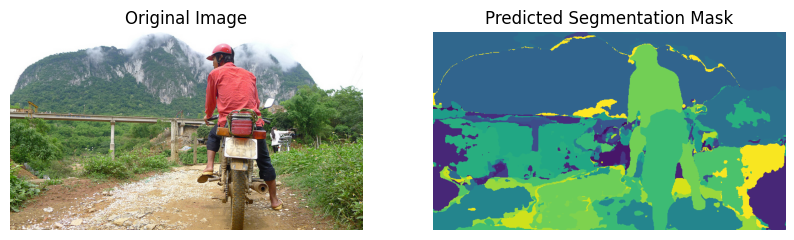

In [ ]:
data_dir = "/var/lit2425/pib/g10/CoCo"
annotation_file = os.path.join(data_dir, "annotations/instances_train2017.json")
coco = COCO(annotation_file)

# Get image IDs and select 10 images
image_ids = coco.getImgIds()[:10]
images = coco.loadImgs(image_ids)

feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50-panoptic")
def get_segmentation_mask(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = feature_extractor(images=image, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    predicted_masks = outputs.pred_masks
    predicted_masks = torch.nn.functional.interpolate(
        predicted_masks, size=image.size[::-1], mode="bilinear", align_corners=False
    )
    segmentation_mask = predicted_masks.argmax(dim=1).squeeze().cpu().numpy()
    return segmentation_mask, image

results = []
for img in images:
    image_path = os.path.join(data_dir, "train2017", img["file_name"])
    segmentation_mask, image = get_segmentation_mask(image_path)
    
    # Load ground truth mask from annotations
    ann_ids = coco.getAnnIds(imgIds=img["id"], iscrowd=None)
    anns = coco.loadAnns(ann_ids)
    gt_mask = np.zeros((img["height"], img["width"]), dtype=np.uint8)
    for ann in anns:
        gt_mask = np.maximum(gt_mask, coco.annToMask(ann))
    
    # Convert predicted mask and ground truth mask to RLE format
    def mask_to_rle(mask):
        rle = maskUtils.encode(np.asfortranarray(mask.astype(np.uint8)))
        rle["counts"] = rle["counts"].decode("utf-8")  
        return rle
    
    pred_rle = mask_to_rle(segmentation_mask)
    gt_rle = mask_to_rle(gt_mask)
    
    # Compute IoU using RLEs
    iou = maskUtils.iou([pred_rle], [gt_rle], [0])  
    results.append(iou[0][0])  

# Calculate average IoU
average_iou = np.mean(results)
print(f"Average IoU over 100 images: {average_iou}")

# Visualize one example
img = images[0]  # First image
image_path = os.path.join(data_dir, "train2017", img["file_name"])
segmentation_mask, image = get_segmentation_mask(image_path)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(segmentation_mask, cmap="viridis")
plt.title("Predicted Segmentation Mask")
plt.axis("off")
plt.show()

In [ ]:
model = DetrForSegmentation.from_pretrained("facebook/detr-resnet-50-panoptic")
feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50-panoptic")

for param in model.parameters():
    param.requires_grad = False


for param in model.mask_head.parameters():
    param.requires_grad = True


data_dir = "/var/lit2425/pib/g10/CoCo"  
annotation_file = os.path.join(data_dir, "annotations/instances_train2017.json")
coco = COCO(annotation_file)

# Testing first with one 1 batch
image_ids = coco.getImgIds()[:4]
images = coco.loadImgs(image_ids)

# Prepare dataset
class CocoSubset(torch.utils.data.Dataset):
    def __init__(self, images, coco, data_dir):
        self.images = images
        self.coco = coco
        self.data_dir = data_dir

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        image_path = os.path.join(self.data_dir, "train2017", img["file_name"])
        image = Image.open(image_path).convert("RGB")
        
        # Load annotations and create mask
        ann_ids = self.coco.getAnnIds(imgIds=img["id"])
        anns = self.coco.loadAnns(ann_ids)
        mask = self.coco.annToMask(anns[0])  
        
        return {"image": image, "mask": mask}

train_dataset = CocoSubset(images, coco, data_dir)


def collate_fn(batch):
    fixed_size = (800, 800)
    
    pixel_values = torch.stack([
        feature_extractor(F.resize(item["image"], fixed_size), return_tensors="pt")["pixel_values"].squeeze(0)
        for item in batch
    ])
    
    masks = torch.stack([
        torch.tensor(np.array(F.resize(Image.fromarray(item["mask"]), fixed_size)), dtype=torch.float32)
        for item in batch
    ])
    
    return {"pixel_values": pixel_values, "masks": masks}


# Create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

# Set up optimizer and loss function
optimizer = torch.optim.AdamW(model.mask_head.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss() 

#Training loop
num_epochs = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)



for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        pixel_values = batch["pixel_values"].to(device)
        masks = batch["masks"].to(device)

        # Forward pass
        outputs = model(pixel_values=pixel_values)
        pred_masks = outputs.pred_masks 

        # Resize predicted masks to match ground truth mask size
        pred_masks_resized = interpolate(
            pred_masks,  
            size=masks.shape[-2:], 
            mode="bilinear",  
            align_corners=False
        ) 

        # Select the first query
        pred_masks_selected = pred_masks_resized[:, 0, :, :] 

        # Compute loss
        loss = criterion(pred_masks_selected, masks)
        epoch_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} Loss: {epoch_loss/len(train_dataloader)}")

model_save_path = "detr_resnet50_panoptic_finetuned.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Some weights of the model checkpoint at facebook/detr-resnet-50-panoptic were not used when initializing DetrForSegmentation: ['detr.model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/var/lit2425/pib/g10/venv/lib/python3.10/site-packages/transform

loading annotations into memory...
Done (t=7.25s)
creating index...
index created!


Epoch 1/3: 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Epoch 1 Loss: 1460.4091796875


Epoch 2/3: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Epoch 2 Loss: 965.1993408203125


Epoch 3/3: 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


Epoch 3 Loss: 895.375732421875
Model saved to detr_resnet50_panoptic_finetuned.pth


In [ ]:
import os
import random
import numpy as np
from PIL import Image
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import functional as F
# from torchvision.transforms import Interpolate
from pycocotools.coco import COCO
from transformers import DetrForSegmentation, DetrFeatureExtractor
from tqdm import tqdm
from torch.nn.functional import interpolate

# Load model and feature extractor
model = DetrForSegmentation.from_pretrained("facebook/detr-resnet-50-panoptic")
feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50-panoptic")

# Freeze all parameters except the mask head
for param in model.parameters():
    param.requires_grad = False

for param in model.mask_head.parameters():
    param.requires_grad = True

# Define COCO dataset class
class COCODataset(torch.utils.data.Dataset):
    def __init__(self, coco, root, subset_size=10, seed=40):
        self.coco = coco
        self.root = root
        
        all_image_ids = coco.getImgIds()
        random.seed(seed)
        sampled_ids = random.sample(all_image_ids, subset_size)
        
        self.image_ids = []
        for img_id in sampled_ids:
            ann_ids = coco.getAnnIds(imgIds=img_id)
            if len(ann_ids) > 0:
                self.image_ids.append(img_id)
        
        print(f"Subset: {len(self.image_ids)}/{subset_size} images have annotations.")
        if len(self.image_ids) == 0:
            raise ValueError("No valid images in subset!")
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.root, img_info['file_name'])
        
        image = Image.open(img_path).convert("RGB")
        
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        
        # Create mask from the first annotation for simplicity
        mask = self.coco.annToMask(anns[0]) if len(anns) > 0 else np.zeros((image.size[1], image.size[0]), dtype=np.uint8)
        
        return {"image": image, "mask": mask}

# Prepare dataset
data_dir = "/var/lit2425/pib/g10/CoCo"
annotation_file = os.path.join(data_dir, "annotations/instances_train2017.json")
coco = COCO(annotation_file)

# Create dataset with random subset
train_dataset = COCODataset(coco, os.path.join(data_dir, "train2017"), subset_size=10, seed=40)

# Collate function
def collate_fn(batch):
    fixed_size = (800, 800)
    
    pixel_values = torch.stack([
        feature_extractor(F.resize(item["image"], fixed_size), return_tensors="pt")["pixel_values"].squeeze(0)
        for item in batch
    ])
    
    masks = torch.stack([
        torch.tensor(np.array(F.resize(Image.fromarray(item["mask"]), fixed_size)), dtype=torch.float32)
        for item in batch
    ])
    
    return {"pixel_values": pixel_values, "masks": masks}

# Create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

# Set up optimizer and loss function
optimizer = torch.optim.AdamW(model.mask_head.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
num_epochs = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        pixel_values = batch["pixel_values"].to(device)
        masks = batch["masks"].to(device)

        # Forward pass
        outputs = model(pixel_values=pixel_values)
        pred_masks = outputs.pred_masks  

        # Resize predicted masks to match ground truth mask size
        pred_masks_resized = interpolate(
            pred_masks,  
            size=masks.shape[-2:],  
            mode="bilinear",  
            align_corners=False
        )  

        # Select the first query (or aggregate queries) for simplicity
        pred_masks_selected = pred_masks_resized[:, 0, :, :]  

        # Compute loss
        loss = criterion(pred_masks_selected, masks)
        epoch_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} Loss: {epoch_loss/len(train_dataloader)}")

# Save the model
model_save_path = "detr_resnet50_panoptic_finetuned2.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Some weights of the model checkpoint at facebook/detr-resnet-50-panoptic were not used when initializing DetrForSegmentation: ['detr.model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/var/lit2425/pib/g10/venv/lib/python3.10/site-packages/transform

loading annotations into memory...
Done (t=8.33s)
creating index...
index created!
Subset: 10/10 images have annotations.


Epoch 1/3: 100%|██████████| 3/3 [00:01<00:00,  2.66it/s]


Epoch 1 Loss: 867.0333251953125


Epoch 2/3: 100%|██████████| 3/3 [00:00<00:00,  3.74it/s]


Epoch 2 Loss: 606.1077372233073


Epoch 3/3:  33%|███▎      | 1/3 [00:00<00:01,  1.67it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.91 GiB. GPU 0 has a total capacity of 15.59 GiB of which 1.56 GiB is free. Including non-PyTorch memory, this process has 13.56 GiB memory in use. Of the allocated memory 8.20 GiB is allocated by PyTorch, and 5.08 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)